In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-whitegrid')
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.optimizers import SGD
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image
import cv2

import warnings
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [2]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [56]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name]) #this line
                X_data.append(process_image(path))   

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

#### Get 'silhouette' data (this is the data we used for the final model)

In [54]:
relative_path = './frames/silhouettes/'
rgb = False

# # This method processes the data
X_data, y_data = walk_file_tree(relative_path)

# Can also optionally use a class to get this data,
# in order to keep it separate from Drawing data
silhouette = Data()
silhouette.X_data, silhouette.y_data = walk_file_tree(relative_path)

In [33]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2748, 224, 224, 3)
y_data shape: (2748, 5)


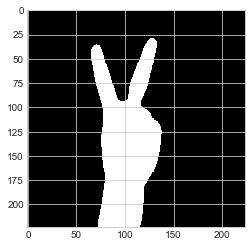

In [34]:
plt.imshow(X_data[0])

#### Get 'drawing' data (this was not used for final model, but I built and tested several models with it)

In [27]:
relative_path = './frames/drawings/'
rgb = True

# This method processes the data
X_data, y_data = walk_file_tree(relative_path)

In [28]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2565, 224, 224, 3)
y_data shape: (2565, 5)


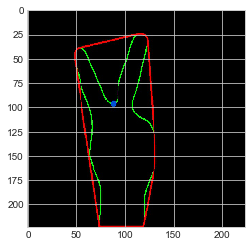

In [29]:
plt.imshow(X_data[0])

In [40]:
# Send the dictionaries to a dataframe to be saved for future use
# d = {'image_path':image_path, 'gesture':gesture, 'image_rgb': image_rgb, 'image_bw_x': X_data, 'image_bw_y': y_data}
d = {'image_path':image_path, 'gesture':gesture}
df = pd.DataFrame(d)
# df['gesture_num'] = df['gesture'].apply(lambda x: x[1:2])
# df['gesture_name'] = df['gesture'].apply(lambda x: x[3:])

# df.to_csv('silhouette_df.csv')
# df = pd.read_csv('silhouette_df.csv')

#### Bring in Kaggle data

In [ ]:
gestures_map = {3 : 0,
                2: 1,
                7: 2,
                1: 3,
                'Peace': 4
                }
X_data = []
y_data = []
gesture = []

root_dir = os.fsencode('./data/gestures_data/')

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        if not file.startswith(b'.'):
            gesture_name = int(file.decode('utf8')[10:11])
            if gesture_name in [1,2,3,7]:
                path = os.path.join(directory, file).decode('utf8')
                gesture.append(gesture_name)
                y_data.append(gestures_map[gesture_name])

                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.flip(img, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (41, 41), 0) #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                thresh = cv2.resize(thresh, (224, 224))
                thresh = np.array(thresh)
                X_data.append(thresh)
                
            else:
                continue
                
process_data(X_data, y_data)

In [ ]:


'''
Have to do this to add a column of zeroes for the 'Peace' sign,
since the Kaggle data does not have photos of 'Peace' signs.
'''
z = np.zeros((len(y_data),1))
y_data = np.append(y_data, z, axis=1)

In [59]:
y_data.shape

(8000, 5)

#### Notice that the Kaggle images are now thresholded and binarized

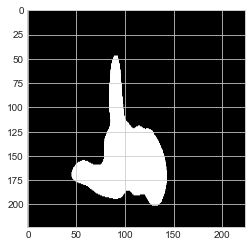

In [75]:
plt.imshow(.5 - X_data[875])

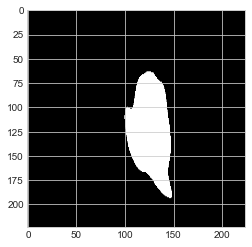

In [76]:
plt.imshow(.5 - X_data[250])

#### Train-test split

In [17]:
# X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(image_rgb, y_data, test_size = 0.2, random_state=12, stratify=y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

#### Build the VGG Model

In [40]:
file_path = 'models/saved_model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0, 
                               patience=10,
                               verbose=1, 
                               mode='auto', 
                               restore_best_weights=True)

In [ ]:
# load VGG16
#Get back the convolutional part of a VGG network trained on ImageNet
import keras
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.models import Model
imageSize=224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = model1 # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5) (x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
      optimizer=optimizers.Adam(), 
      metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_data, y_data), verbose=1, callbacks =[early_stopping, model_checkpoint])

'''
# Uncomment the section below and use in lieu of model.fit() above
# if using image augmentation. Our final model did not.

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

datagen.fit(X_train)

fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train)/32, epochs=150, validation_data=(X_test, y_test))
'''

#### Save and import model

In [88]:
# model.save('models/VGG_reversed.h5')

from keras.models import load_model
model = load_model('/home/ubuntu/project_kojak/models/VGG_reversed.h5')

#### Get classification metrics

In [48]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

**VGG_cross_validated model**

Note that there are no predictions for class \#5 since 'Peace' sign did not exist in cross_val images

In [49]:
# get_classification_metrics(X_data, y_data)

[[200   0   0   0   0]
 [  0 199   0   1   0]
 [  0   0 200   0   0]
 [ 11   0   0 187   2]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       200
           1       1.00      0.99      1.00       200
           2       1.00      1.00      1.00       200
           3       0.99      0.94      0.96       200
           4       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.99      0.98      0.98       800



#### Predict gesture on a single image

In [63]:
gesture_names = {0: 'C',
                 1: 'Fist',
                 2: 'L',
                 3: 'Okay',
                 4: 'Palm',
                 5: 'Peace'}

def predict_rgb_image(path):
    img2rgb = image_utils.load_img(path=path, target_size=(224, 224))
    img2rgb = image_utils.img_to_array(img2rgb)
    img2rgb = img2rgb.reshape(1, 224, 224, 3)
    return gesture_names[np.argmax(model.predict(img2rgb))]

In [ ]:
predict_rgb_image('images_to_predict/test - palm.jpg')

#### Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_rgb)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=32),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))

In [80]:
model.save('models/new_new_new.h5')

In [109]:
np.argmax(model.predict(X_test_rgb[0].reshape(1,224,224,3)))

4

#### Build own model
Note that we ended up using the model on top of VGG, not this one.

In [78]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(5, activation='softmax'))

In [79]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train[:500], y_train[:500], epochs=4, batch_size=64, validation_data=(X_test[:500], y_test[:500]), verbose=1, callbacks = [MetricsCheckpoint('logs')])

In [80]:
model.fit(X_train_rgb, y_train_rgb, epochs=200, batch_size=16, validation_data=(X_test_rgb, y_test_rgb), verbose=1, callbacks =[early_stopping, model_checkpoint])

Train on 1020 samples, validate on 256 samples
Epoch 1/200
1020/1020 [==============================] - 2s 2ms/step - loss: 1.4084 - acc: 0.4069 - val_loss: 1.1192 - val_acc: 0.5703
Epoch 2/200
1020/1020 [==============================] - 1s 746us/step - loss: 0.6555 - acc: 0.7657 - val_loss: 0.6208 - val_acc: 0.7930
Epoch 3/200
1020/1020 [==============================] - 1s 637us/step - loss: 0.2596 - acc: 0.9039 - val_loss: 0.4631 - val_acc: 0.8438
Epoch 4/200
1020/1020 [==============================] - 1s 708us/step - loss: 0.1080 - acc: 0.9627 - val_loss: 0.6910 - val_acc: 0.8359
Epoch 5/200
1020/1020 [==============================] - 1s 664us/step - loss: 0.0659 - acc: 0.9775 - val_loss: 0.6188 - val_acc: 0.8242
Epoch 6/200
1020/1020 [==============================] - 1s 703us/step - loss: 0.0566 - acc: 0.9794 - val_loss: 0.5668 - val_acc: 0.8633
Epoch 7/200
1020/1020 [==============================] - 1s 661us/step - loss: 0.0515 - acc: 0.9833 - val_loss: 0.5964 - val_acc: 0.8

In [99]:
def get_classification_reports(y_pred, y_true):
    Y_pred_classes = np.array(np.argmax(y_pred))  # reconverts back from one hot encoded 
    Y_true = np.array(np.argmax(y_true))  # reconverts back from one hot encoded
    print(confusion_matrix(Y_true, Y_pred_classes))
    print(classification_report(Y_true, Y_pred_classes))

#### Classification metrics for an earlier version of the model

In [86]:
print(classification_report(Y_pred_classes, Y_true))

             precision    recall  f1-score   support

          0       0.91      0.89      0.90        44
          1       0.86      0.95      0.90        39
          2       0.90      0.81      0.85        53
          3       0.85      0.91      0.88        44
          4       0.95      0.93      0.94        76

avg / total       0.90      0.90      0.90       256



In [87]:
print(confusion_matrix(Y_pred_classes, Y_true))

[[39  2  0  2  1]
 [ 0 37  1  1  0]
 [ 3  3 43  3  1]
 [ 1  0  1 40  2]
 [ 0  1  3  1 71]]
